In [2]:
# Imported all modules I would need.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time

from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier

In [2]:
# Set notebook's random seed to 22.
np.random.seed(22)

## **Preprocessing**

In [3]:
# Created a DataFrame from the subreddits.csv file, which contained the cleaned data.
subreddits_df = pd.read_csv('./data/subreddits.csv')

In [4]:
# Looked at the DataFrame and confirmed its size and columns were correct.
subreddits_df

,title,subreddit
0,4 months post booster and i have &gt;2500 spik...,CovidVaccinated
1,"If you got the COVID vaccine(s), but were orig...",CovidVaccinated
2,Nasty cough after booster (Moderna) / experien...,CovidVaccinated
3,Getting another booster after experiencing myo...,CovidVaccinated
4,why do so many people say not to get jj?,CovidVaccinated
...,...,...
13562,Thought terminating cliché - Please familiariz...,DebateVaccines
13563,/r/confession - I use pseudo profiles on Faceb...,DebateVaccines
13564,/r/confessions - I use pseudo profiles on Face...,DebateVaccines
13565,How To Out A Vaccine Shill. Start talking abou...,DebateVaccines


In [5]:
# Obtained guidance for creating stemming function from: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Created function named "stemming_tokenizer" which would later be thrown into the range of tokenizer hyperparameters I performed a RandomizedSearchCV on.
def stemming_tokenizer(doc):
    ps = PorterStemmer()
    return [ps.stem(w) for w in word_tokenize(doc)]

In [6]:
# Obtained lemmatization function from class notebook.
# Created function named "lemma_tokenizer" which would later be thrown into the range of tokenizer hyperparameters I performed a RandomizedSearchCV on.
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

In [7]:
# Defined my one feature, the target vector, and proceed to perform a train/test split with a random_state of 42 while stratifying on the label.
X = subreddits_df['title']
y = subreddits_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [8]:
# Looked at the noramlized value_counts in the target vector.
y.value_counts(normalize=True)

DebateVaccines     0.503575
CovidVaccinated    0.496425
Name: subreddit, dtype: float64

## **Modeling**

### **Baseline Model**

In [9]:
# Instantiated DummyClassifier object and proceeded to fit it on the X_train and y_train before scoring both X_train/y_train and X_test/y_test.
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_train, y_train), dc.score(X_test, y_test)

(0.5035872235872236, 0.5035377358490566)

In [10]:
# Utilized the fitted DummyClassifier object to predict the target and saved the results under variable named "baseline_preds".
baseline_preds = dc.predict(X_test)

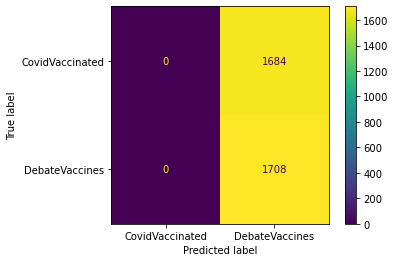

In [11]:
# Generated a ConfusionMatrixDisplay utilizing this DummyClassifier estimator.
ConfusionMatrixDisplay.from_estimator(dc, X_test, y_test);

In [12]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
baseline_precision = precision_score(y_test, baseline_preds, pos_label='CovidVaccinated')
baseline_precision

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [13]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
baseline_recall = recall_score(y_test, baseline_preds, pos_label='CovidVaccinated')
baseline_recall

0.0

In [14]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
baseline_f1 = f1_score(y_test, baseline_preds, pos_label='CovidVaccinated')
baseline_f1

0.0

### **CountVectorizer**

#### CountVectorizer + Logistic Regression

In [10]:
# Created a pipeline object with a CountVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_logreg_pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10_000))
cvec_logreg_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('logisticregression', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'logisticregression': LogisticRegression(max_iter=10000),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticre

In [11]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_logreg_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer], 
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [12]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_logreg_rs = RandomizedSearchCV(cvec_logreg_pipe, param_distributions=cvec_logreg_params, n_jobs=-1)

In [13]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_rs.fit(X_train, y_train)
cvec_logreg_rs.score(X_train, y_train), cvec_logreg_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.8800982800982801, 0.8499410377358491)

In [14]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_logreg_rs.best_params_

{'logisticregression__solver': 'lbfgs',
 'logisticregression__penalty': 'l2',
 'logisticregression__C': 0.1,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [15]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_logreg_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [lemma_tokenizer], 
    'logisticregression__C': [0.1, 0.2, 0.3],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs']
}

##### Hyperparameter Tuning using GridSearchCV

In [16]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_logreg_gs = GridSearchCV(cvec_logreg_pipe, param_grid=cvec_logreg_new_params, n_jobs=-1)

In [17]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_gs.fit(X_train, y_train)
cvec_logreg_gs.score(X_train, y_train), cvec_logreg_gs.score(X_test, y_test)

(0.9622604422604423, 0.8584905660377359)

In [18]:
# Utilized the fitted DummyClassifier object to predict the target and saved the results under variable named "baseline_preds".
cvec_logreg_gs_preds = cvec_logreg_gs.predict(X_test)

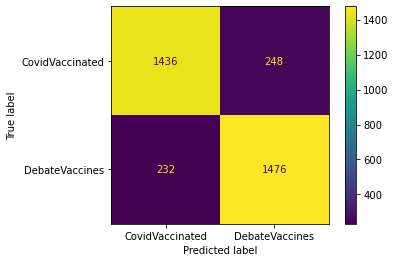

In [19]:
# Generated a ConfusionMatrixDisplay utilizing this DummyClassifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_logreg_gs, X_test, y_test);

In [20]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_logreg_gs_precision = precision_score(y_test, cvec_logreg_gs_preds, pos_label='CovidVaccinated')
cvec_logreg_gs_precision

0.8609112709832134

In [21]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_logreg_gs_recall = recall_score(y_test, cvec_logreg_gs_preds, pos_label='CovidVaccinated')
cvec_logreg_gs_recall

0.8527315914489311

In [22]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_logreg_gs_f1 = f1_score(y_test, cvec_logreg_gs_preds, pos_label='CovidVaccinated')
cvec_logreg_gs_f1

0.8568019093078759

In [23]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_logreg_gs.best_params_

{'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'logisticregression__C': 0.3,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

#### CountVectorizer + KNeighborsClassifier

In [24]:
# Created a pipeline object with a CountVectorizer transformer and KNeighbors classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_knn_pipe = make_pipeline(CountVectorizer(), KNeighborsClassifier())
cvec_knn_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier

In [25]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_knn_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 5, 10]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [26]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_knn_rs = RandomizedSearchCV(cvec_knn_pipe, param_distributions=cvec_knn_params, n_jobs=-1)

In [27]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_rs.fit(X_train, y_train)
cvec_knn_rs.score(X_train, y_train), cvec_knn_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.804029484029484, 0.7069575471698113)

In [28]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_knn_rs.best_params_

{'kneighborsclassifier__n_neighbors': 5,
 'countvectorizer__tokenizer': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [29]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_knn_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [None],
    'kneighborsclassifier__n_neighbors': [3, 5, 7]
}

##### Hyperparameter Tuning using GridSearchCV

In [30]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_knn_gs = GridSearchCV(cvec_knn_pipe, param_grid=cvec_knn_new_params, n_jobs=-1)

In [33]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_gs.fit(X_train, y_train)
cvec_knn_gs.score(X_train, y_train), cvec_knn_gs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(0.7872235872235872, 0.7160966981132075)

In [34]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_knn_gs_preds".
cvec_knn_gs_preds = cvec_knn_gs.predict(X_test)

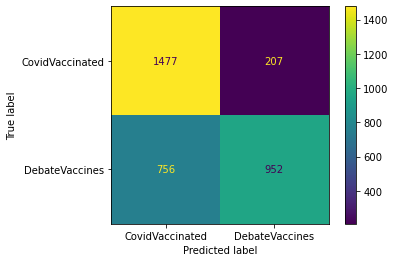

In [35]:
# Generated a ConfusionMatrixDisplay utilizing this KNeighborsClassifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_knn_gs, X_test, y_test);

In [36]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_knn_gs_precision = precision_score(y_test, cvec_knn_gs_preds, pos_label='CovidVaccinated')
cvec_knn_gs_precision

0.6614420062695925

In [37]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_knn_gs_recall = recall_score(y_test, cvec_knn_gs_preds, pos_label='CovidVaccinated')
cvec_knn_gs_recall

0.8770783847980997

In [38]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_knn_gs_f1 = f1_score(y_test, cvec_knn_gs_preds, pos_label='CovidVaccinated')
cvec_knn_gs_f1

0.7541485830993107

In [39]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_knn_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': None,
 'kneighborsclassifier__n_neighbors': 7}

#### CountVectorizer + SVC

In [40]:
# Created a pipeline object with a CountVectorizer transformer and Support Vector Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_svc_pipe = make_pipeline(CountVectorizer(), SVC())
cvec_svc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()), ('svc', SVC())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'svc': SVC(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 

In [43]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_svc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'svc__C': [1.0, .1]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [44]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_svc_rs = RandomizedSearchCV(cvec_svc_pipe, param_distributions=cvec_svc_params, n_jobs=-1)

In [45]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_rs.fit(X_train, y_train)
cvec_svc_rs.score(X_train, y_train), cvec_svc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.9316953316953317, 0.8481721698113207)

In [46]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_svc_rs.best_params_

{'svc__C': 1.0,
 'countvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [47]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_svc_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'svc__C': [1.0, .9, .8]
}

##### Hyperparameter Tuning using GridSearchCV

In [48]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_svc_gs = GridSearchCV(cvec_svc_pipe, param_grid=cvec_svc_new_params, n_jobs=-1)

In [49]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_gs.fit(X_train, y_train)
cvec_svc_gs.score(X_train, y_train), cvec_svc_gs.score(X_test, y_test)

(0.9316953316953317, 0.8481721698113207)

In [50]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_svc_gs_preds".
cvec_svc_gs_preds = cvec_svc_gs.predict(X_test)

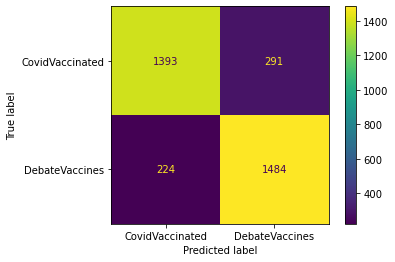

In [51]:
# Generated a ConfusionMatrixDisplay utilizing this Suppert Vector Classifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_svc_gs, X_test, y_test);

In [52]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_svc_gs_precision = precision_score(y_test, cvec_svc_gs_preds, pos_label='CovidVaccinated')
cvec_svc_gs_precision

0.8614718614718615

In [53]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_svc_gs_recall = recall_score(y_test, cvec_svc_gs_preds, pos_label='CovidVaccinated')
cvec_svc_gs_recall

0.8271971496437055

In [54]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_svc_gs_f1 = f1_score(y_test, cvec_svc_gs_preds, pos_label='CovidVaccinated')
cvec_svc_gs_f1

0.8439866707058468

In [55]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_svc_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'svc__C': 1.0}

#### CountVectorizer + MultinomialNB

In [14]:
# Created a pipeline object with a CountVectorizer transformer and Multinomial Naives Bayes Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_mnb_pipe = make_pipeline(CountVectorizer(), MultinomialNB())
cvec_mnb_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'multinomialnb': MultinomialNB(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True}

In [15]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_mnb_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'multinomialnb__alpha': [1.0, .5, .1]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [16]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_mnb_rs = RandomizedSearchCV(cvec_mnb_pipe, param_distributions=cvec_mnb_params, n_jobs=-1)

In [17]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_rs.fit(X_train, y_train)
cvec_mnb_rs.score(X_train, y_train), cvec_mnb_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.9044717444717445, 0.8670400943396226)

In [18]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_mnb_rs.best_params_

{'multinomialnb__alpha': 0.5,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [19]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_mnb_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'multinomialnb__alpha': [0.4, 0.5, 0.6]
}

##### Hyperparameter Tuning using GridSearchCV

In [20]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_mnb_gs = GridSearchCV(cvec_mnb_pipe, param_grid=cvec_mnb_new_params, n_jobs=-1)

In [21]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_gs.fit(X_train, y_train)
cvec_mnb_gs.score(X_train, y_train), cvec_mnb_gs.score(X_test, y_test)

(0.9067321867321867, 0.8670400943396226)

In [22]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_mnb_gs_preds".
cvec_mnb_gs_preds = cvec_mnb_gs.predict(X_test)

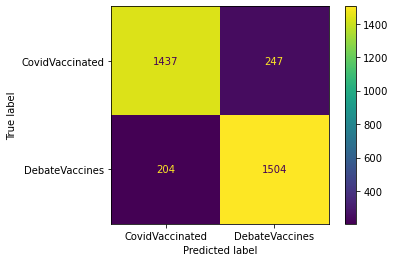

In [23]:
# Generated a ConfusionMatrixDisplay utilizing this Multinomial Naives Bayes Classifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_mnb_gs, X_test, y_test);

In [24]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_mnb_gs_precision = precision_score(y_test, cvec_mnb_gs_preds, pos_label='CovidVaccinated')
cvec_mnb_gs_precision

0.8756855575868373

In [25]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_mnb_gs_recall = recall_score(y_test, cvec_mnb_gs_preds, pos_label='CovidVaccinated')
cvec_mnb_gs_recall

0.8533254156769596

In [26]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_mnb_gs_f1 = f1_score(y_test, cvec_mnb_gs_preds, pos_label='CovidVaccinated')
cvec_mnb_gs_f1

0.8643609022556391

In [27]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_mnb_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'multinomialnb__alpha': 0.4}

#### CountVectorizer + DecisionTreeClassifier

In [70]:
# Created a pipeline object with a CountVectorizer transformer and Decision Tree Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_dtc_pipe = make_pipeline(CountVectorizer(), DecisionTreeClassifier())
cvec_dtc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisi

In [71]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_dtc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__max_features': [None, 1_000, 2_000],
    'decisiontreeclassifier__min_samples_split': [None, 2, 5]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [72]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_dtc_rs = RandomizedSearchCV(cvec_dtc_pipe, param_distributions=cvec_dtc_params, n_jobs=-1)

In [73]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_rs.fit(X_train, y_train)
cvec_dtc_rs.score(X_train, y_train), cvec_dtc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.9963636363636363, 0.7653301886792453)

In [74]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_dtc_rs.best_params_

{'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_depth': None,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [75]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_dtc_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'decisiontreeclassifier__max_depth': [None],
    'decisiontreeclassifier__max_features': [None],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4]
}

##### Hyperparameter Tuning using GridSearchCV

In [76]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_dtc_gs = GridSearchCV(cvec_dtc_pipe, param_grid=cvec_dtc_new_params, n_jobs=-1)

In [79]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_gs.fit(X_train, y_train)
cvec_dtc_gs.score(X_train, y_train), cvec_dtc_gs.score(X_test, y_test)

(0.9898771498771499, 0.7783018867924528)

In [80]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_dtc_gs_preds".
cvec_dtc_gs_preds = cvec_dtc_gs.predict(X_test)

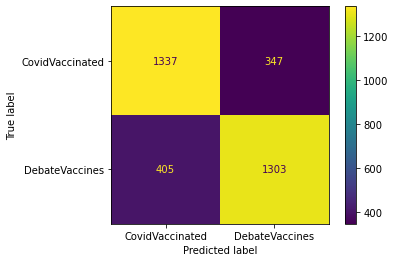

In [81]:
# Generated a ConfusionMatrixDisplay utilizing this Decision Tree Classifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_dtc_gs, X_test, y_test);

In [82]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_dtc_gs_precision = precision_score(y_test, cvec_dtc_gs_preds, pos_label='CovidVaccinated')
cvec_dtc_gs_precision

0.7675086107921929

In [83]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_dtc_gs_recall = recall_score(y_test, cvec_dtc_gs_preds, pos_label='CovidVaccinated')
cvec_dtc_gs_recall

0.7939429928741093

In [84]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_dtc_gs_f1 = f1_score(y_test, cvec_dtc_gs_preds, pos_label='CovidVaccinated')
cvec_dtc_gs_f1

0.780502043199066

In [85]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_dtc_gs.best_params_

{'countvectorizer__ngram_range': (1, 3),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__min_samples_split': 4}

#### CountVectorizer + ExtraTreesClassifier

In [86]:
# Created a pipeline object with a CountVectorizer transformer and Extra Trees Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_etc_pipe = make_pipeline(CountVectorizer(), ExtraTreesClassifier())
cvec_etc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('extratreesclassifier', ExtraTreesClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'extratreesclassifier': ExtraTreesClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'extratreesclassifier__bootstrap': False,
 'extratreesclassifier__ccp_alpha': 0.0,
 'extratreesclassifier

In [87]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_etc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'extratreesclassifier__max_depth': [None, 5, 10, 15, 20],
    'extratreesclassifier__max_features': [None, 1_000, 2_000],
    'extratreesclassifier__min_samples_split': [2, 3, 4],
    'extratreesclassifier__n_estimators': [100, 150, 200]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [88]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_etc_rs = RandomizedSearchCV(cvec_etc_pipe, param_distributions=cvec_etc_params, n_jobs=-1)

In [89]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_rs.fit(X_train, y_train)
cvec_etc_rs.score(X_train, y_train), cvec_etc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.994987714987715, 0.8130896226415094)

In [90]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_etc_rs.best_params_

{'extratreesclassifier__n_estimators': 200,
 'extratreesclassifier__min_samples_split': 4,
 'extratreesclassifier__max_features': None,
 'extratreesclassifier__max_depth': None,
 'countvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [91]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_etc_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'extratreesclassifier__max_depth': [None],
    'extratreesclassifier__max_features': [None],
    'extratreesclassifier__min_samples_split': [4],
    'extratreesclassifier__n_estimators': [200]
}

##### Hyperparameter Tuning using GridSearchCV

In [92]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_etc_gs = GridSearchCV(cvec_etc_pipe, param_grid=cvec_etc_new_params, n_jobs=-1)

In [93]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_gs.fit(X_train, y_train)
cvec_etc_gs.score(X_train, y_train), cvec_etc_gs.score(X_test, y_test)

(0.9958722358722358, 0.8098466981132075)

In [94]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_etc_gs_preds".
cvec_etc_gs_preds = cvec_etc_gs.predict(X_test)

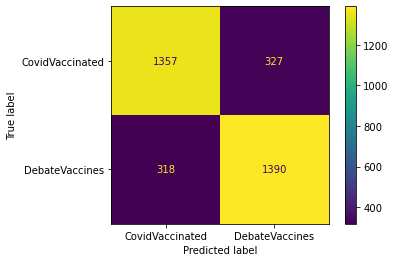

In [95]:
# Generated a ConfusionMatrixDisplay utilizing this Extra Trees Classifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_etc_gs, X_test, y_test);

In [96]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_etc_gs_precision = precision_score(y_test, cvec_etc_gs_preds, pos_label='CovidVaccinated')
cvec_etc_gs_precision

0.8101492537313433

In [97]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_etc_gs_recall = recall_score(y_test, cvec_etc_gs_preds, pos_label='CovidVaccinated')
cvec_etc_gs_recall

0.8058194774346793

In [98]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_etc_gs_f1 = f1_score(y_test, cvec_etc_gs_preds, pos_label='CovidVaccinated')
cvec_etc_gs_f1

0.8079785650491218

In [99]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_etc_gs.best_params_

{'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'extratreesclassifier__max_depth': None,
 'extratreesclassifier__max_features': None,
 'extratreesclassifier__min_samples_split': 4,
 'extratreesclassifier__n_estimators': 200}

#### CountVectorizer + RandomForestClassifier

In [102]:
# Created a pipeline object with a CountVectorizer transformer and Random Forest Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_rfc_pipe = make_pipeline(CountVectorizer(), RandomForestClassifier())
cvec_rfc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'randomforestclassifier': RandomForestClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomfor

In [103]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_rfc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__max_features': [None, 1_000, 2_000],
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__n_estimators': [100, 150, 200]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [104]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_rfc_rs = RandomizedSearchCV(cvec_rfc_pipe, param_distributions=cvec_rfc_params, n_jobs=-1)

In [105]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_rs.fit(X_train, y_train)
cvec_rfc_rs.score(X_train, y_train), cvec_rfc_rs.score(X_test, y_test)

(0.8377395577395578, 0.7918632075471698)

In [106]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_rfc_rs.best_params_

{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__max_depth': 15,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [107]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_rfc_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'randomforestclassifier__max_depth': [15],
    'randomforestclassifier__max_features': [None],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__n_estimators': [200]
}

##### Hyperparameter Tuning using GridSearchCV

In [108]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_rfc_gs = GridSearchCV(cvec_rfc_pipe, param_grid=cvec_rfc_new_params, n_jobs=-1)

In [109]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_gs.fit(X_train, y_train)
cvec_rfc_gs.score(X_train, y_train), cvec_rfc_gs.score(X_test, y_test)

(0.8385257985257986, 0.7897995283018868)

In [110]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_rfc_gs_preds".
cvec_rfc_gs_preds = cvec_rfc_gs.predict(X_test)

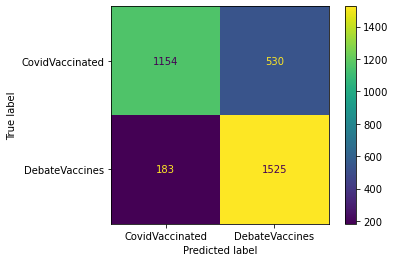

In [111]:
# Generated a ConfusionMatrixDisplay utilizing this Random Forest Classifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_rfc_gs, X_test, y_test);

In [112]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_rfc_gs_precision = precision_score(y_test, cvec_rfc_gs_preds, pos_label='CovidVaccinated')
cvec_rfc_gs_precision

0.8631264023934181

In [113]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_rfc_gs_recall = recall_score(y_test, cvec_rfc_gs_preds, pos_label='CovidVaccinated')
cvec_rfc_gs_recall

0.6852731591448931

In [114]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_rfc_gs_f1 = f1_score(y_test, cvec_rfc_gs_preds, pos_label='CovidVaccinated')
cvec_rfc_gs_f1

0.763985435286329

In [115]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_rfc_gs.best_params_

{'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 200}

#### CountVectorizer + GradientBoostingClassifier

In [116]:
# Created a pipeline object with a CountVectorizer transformer and Gradient Boosting Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_gbc_pipe = make_pipeline(CountVectorizer(), GradientBoostingClassifier())
cvec_gbc_pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('gradientboostingclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'gradientboostingclassifier': GradientBoostingClassifier(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__crite

In [118]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_gbc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [None, 'english'],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'gradientboostingclassifier__max_depth': [None, 5, 10, 15, 20],
    'gradientboostingclassifier__max_features': [None, 1_000, 2_000],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [100, 150, 200]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [119]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_gbc_rs = RandomizedSearchCV(cvec_gbc_pipe, param_distributions=cvec_gbc_params, n_jobs=-1)

In [120]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_rs.fit(X_train, y_train)
cvec_gbc_rs.score(X_train, y_train), cvec_gbc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.9106633906633906, 0.8419811320754716)

In [121]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_gbc_rs.best_params_

{'gradientboostingclassifier__n_estimators': 100,
 'gradientboostingclassifier__min_samples_split': 3,
 'gradientboostingclassifier__max_features': 1000,
 'gradientboostingclassifier__max_depth': 10,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'countvectorizer__stop_words': None,
 'countvectorizer__ngram_range': (1, 1)}

In [122]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_gbc_new_params = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'countvectorizer__stop_words': [None],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'gradientboostingclassifier__max_depth': [10],
    'gradientboostingclassifier__max_features': [1_000],
    'gradientboostingclassifier__min_samples_split': [3],
    'gradientboostingclassifier__n_estimators': [100]
}

##### Hyperparameter Tuning using GridSearchCV

In [123]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_gbc_gs = GridSearchCV(cvec_gbc_pipe, param_grid=cvec_gbc_new_params, n_jobs=-1)

In [124]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_gs.fit(X_train, y_train)
cvec_gbc_gs.score(X_train, y_train), cvec_gbc_gs.score(X_test, y_test)

(0.894938574938575, 0.8458136792452831)

In [125]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_gbc_gs_preds".
cvec_gbc_gs_preds = cvec_gbc_gs.predict(X_test)

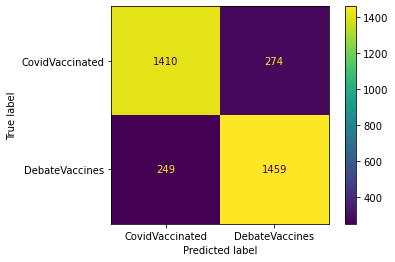

In [126]:
# Generated a ConfusionMatrixDisplay utilizing this Gradient Boosting Classifier estimator.
ConfusionMatrixDisplay.from_estimator(cvec_gbc_gs, X_test, y_test);

In [127]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
cvec_gbc_gs_precision = precision_score(y_test, cvec_gbc_gs_preds, pos_label='CovidVaccinated')
cvec_gbc_gs_precision

0.8499095840867993

In [128]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
cvec_gbc_gs_recall = recall_score(y_test, cvec_gbc_gs_preds, pos_label='CovidVaccinated')
cvec_gbc_gs_recall

0.83729216152019

In [129]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
cvec_gbc_gs_f1 = f1_score(y_test, cvec_gbc_gs_preds, pos_label='CovidVaccinated')
cvec_gbc_gs_f1

0.8435536942865689

In [130]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_gbc_gs.best_params_

{'countvectorizer__ngram_range': (1, 3),
 'countvectorizer__stop_words': None,
 'countvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'gradientboostingclassifier__max_depth': 10,
 'gradientboostingclassifier__max_features': 1000,
 'gradientboostingclassifier__min_samples_split': 3,
 'gradientboostingclassifier__n_estimators': 100}

### **TfidfVectorizer**

#### TfidfVectorizer + Logistic Regression

In [141]:
# Created a pipeline object with a TfidfVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_logreg_pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=10_000))
tfidf_logreg_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('logisticregression', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'logisticregression': LogisticRegression(max_iter=10000),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvect

In [142]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_logreg_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [143]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_logreg_rs = RandomizedSearchCV(tfidf_logreg_pipe, param_distributions=tfidf_logreg_params, n_jobs=-1)

In [144]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_logreg_rs.fit(X_train, y_train)
tfidf_logreg_rs.score(X_train, y_train), tfidf_logreg_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.6253562653562653, 0.6017099056603774)

In [145]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_logreg_rs.best_params_

{'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.2,
 'tfidfvectorizer__max_df': 0.9,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__penalty': 'l2',
 'logisticregression__C': 0.1}

In [146]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_logreg_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': [None],
    'tfidfvectorizer__tokenizer': [None],
    'logisticregression__C': [.1, .2, .3],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs']
}

##### Hyperparameter Tuning using GridSearchCV

In [147]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_logreg_gs = GridSearchCV(tfidf_logreg_pipe, param_grid=tfidf_logreg_new_params, n_jobs=-1)

In [148]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_logreg_gs.fit(X_train, y_train)
tfidf_logreg_gs.score(X_train, y_train), tfidf_logreg_gs.score(X_test, y_test)

(0.6253562653562653, 0.6017099056603774)

In [149]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_logreg_gs_preds".
tfidf_logreg_gs_preds = tfidf_logreg_gs.predict(X_test)

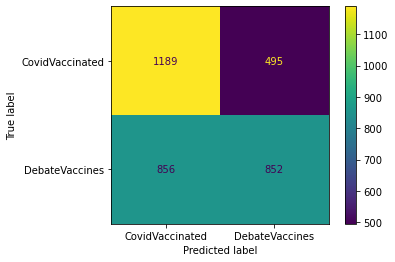

In [150]:
# Generated a ConfusionMatrixDisplay utilizing this Logistic Regression estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_logreg_gs, X_test, y_test);

In [151]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_logreg_gs_precision = precision_score(y_test, tfidf_logreg_gs_preds, pos_label='CovidVaccinated')
tfidf_logreg_gs_precision

0.5814180929095355

In [152]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_logreg_gs_recall = recall_score(y_test, tfidf_logreg_gs_preds, pos_label='CovidVaccinated')
tfidf_logreg_gs_recall

0.7060570071258907

In [153]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_logreg_gs_f1 = f1_score(y_test, tfidf_logreg_gs_preds, pos_label='CovidVaccinated')
tfidf_logreg_gs_f1

0.6377044784124429

In [154]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_logreg_gs.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs',
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__min_df': 0.2,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__tokenizer': None}

#### TfidfVectorizer + KNeighborsClassifier

In [155]:
# Created a pipeline object with a TfidfVectorizer transformer and KNeighbors Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_knn_pipe = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
tfidf_knn_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': Tr

In [156]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_knn_params = {
    'tfidfvectorizer__max_df': [.9, .8, .7],
    'tfidfvectorizer__min_df': [.1, .3, .5], 
    'tfidfvectorizer__ngram_range': [(1,1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 5, 10]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [157]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_knn_rs = RandomizedSearchCV(tfidf_knn_pipe, param_distributions=tfidf_knn_params, n_jobs=-1)

In [158]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_knn_rs.fit(X_train, y_train)
tfidf_knn_rs.score(X_train, y_train), tfidf_knn_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.5941031941031941, 0.5857900943396226)

In [159]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_knn_rs.best_params_

{'tfidfvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__max_df': 0.7,
 'kneighborsclassifier__n_neighbors': 2}

In [160]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_knn_new_params = {
    'tfidfvectorizer__max_df': [.7],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 3, 4]
}

##### Hyperparameter Tuning using GridSearchCV

In [161]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_knn_gs = GridSearchCV(tfidf_knn_pipe, param_grid=tfidf_knn_new_params, n_jobs=-1)

In [162]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_knn_gs.fit(X_train, y_train)
tfidf_knn_gs.score(X_train, y_train), tfidf_knn_gs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.6484520884520885, 0.6420990566037735)

In [163]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_knn_gs_preds".
tfidf_knn_gs_preds = tfidf_knn_gs.predict(X_test)

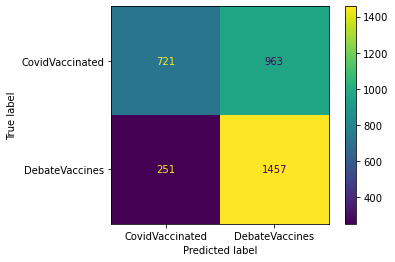

In [164]:
# Generated a ConfusionMatrixDisplay utilizing this KNeighbors Classifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_knn_gs, X_test, y_test);

In [165]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_knn_gs_precision = precision_score(y_test, tfidf_knn_gs_preds, pos_label='CovidVaccinated')
tfidf_knn_gs_precision

0.7417695473251029

In [166]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_knn_gs_recall = recall_score(y_test, tfidf_knn_gs_preds, pos_label='CovidVaccinated')
tfidf_knn_gs_recall

0.42814726840855105

In [167]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_knn_gs_f1 = f1_score(y_test, tfidf_knn_gs_preds, pos_label='CovidVaccinated')
tfidf_knn_gs_f1

0.5429216867469879

In [168]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 3,
 'tfidfvectorizer__max_df': 0.7,
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>}

#### TfidfVectorizer + SVC

In [171]:
# Created a pipeline object with a TfidfVectorizer transformer and Support Vector Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_svc_pipe = make_pipeline(TfidfVectorizer(), SVC())
tfidf_svc_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'svc': SVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocabulary': None,
 'svc__C': 1.0,
 'svc__break

In [172]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_svc_params = {
    'tfidfvectorizer__max_df': [.9, .8, .7],
    'tfidfvectorizer__min_df': [.1, .3, .5], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'svc__C': [1.0, .1]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [173]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_svc_rs = RandomizedSearchCV(tfidf_svc_pipe, param_distributions=tfidf_svc_params, n_jobs=-1)

In [174]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_svc_rs.fit(X_train, y_train)
tfidf_svc_rs.score(X_train, y_train), tfidf_svc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.6588697788697788, 0.6701061320754716)

In [175]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_svc_rs.best_params_

{'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__max_df': 0.8,
 'svc__C': 0.1}

In [176]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_svc_new_params = {
    'tfidfvectorizer__max_df': [.7, .8, .9],
    'tfidfvectorizer__min_df': [.1, .2, .3], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [None],
    'svc__C': [.1, .2, .3]
}

##### Hyperparameter Tuning using GridSearchCV

In [177]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_svc_gs = GridSearchCV(tfidf_svc_pipe, param_grid=tfidf_svc_new_params, n_jobs=-1)

In [178]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_svc_gs.fit(X_train, y_train)
tfidf_svc_gs.score(X_train, y_train), tfidf_svc_gs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/

(0.6588697788697788, 0.6701061320754716)

In [179]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_svc_gs_preds".
tfidf_svc_gs_preds = tfidf_svc_gs.predict(X_test)

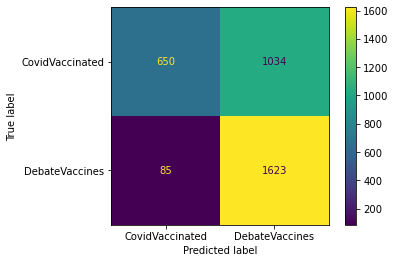

In [180]:
# Generated a ConfusionMatrixDisplay utilizing this Support Vector Classifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_svc_gs, X_test, y_test);

In [181]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_svc_gs_precision = precision_score(y_test, tfidf_svc_gs_preds, pos_label='CovidVaccinated')
tfidf_svc_gs_precision

0.8843537414965986

In [182]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_svc_gs_recall = recall_score(y_test, tfidf_svc_gs_preds, pos_label='CovidVaccinated')
tfidf_svc_gs_recall

0.3859857482185273

In [183]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_svc_gs_f1 = f1_score(y_test, tfidf_svc_gs_preds, pos_label='CovidVaccinated')
tfidf_svc_gs_f1

0.5374121537825548

In [184]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_svc_gs.best_params_

{'svc__C': 0.2,
 'tfidfvectorizer__max_df': 0.7,
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__tokenizer': None}

#### TfidfVectorizer + GaussianNB

In [64]:
# Instantiated an object of the GaussianNB class.
tfidf_gnb = GaussianNB()

In [65]:
# Fit the GaussianNB object on the array version of the TFIDF-vectorized titles (X_train) and y_train before scoring on both the X_train array/y_train and X_test array/y_test. 
tfidf_gnb.fit(X_train_tfidf_vec.A, y_train)
tfidf_gnb.score(X_train_tfidf_vec.A, y_train), tfidf_gnb.score(X_test_tfidf_vec.A, y_test)

(0.7168550368550368, 0.7163915094339622)

In [66]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_gnb_preds".
tfidf_gnb_preds = tfidf_gnb.predict(X_test_tfidf_vec.A)

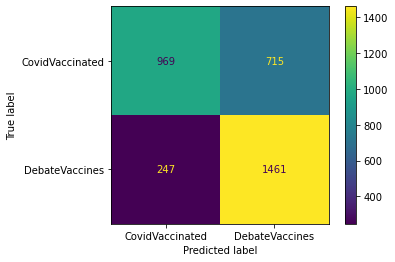

In [67]:
# Generated a ConfusionMatrixDisplay utilizing this Gaussian Naives Bayes Classifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_gnb, X_test_tfidf_vec.A, y_test);

In [68]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_gnb_precision = precision_score(y_test, tfidf_gnb_preds, pos_label='CovidVaccinated')
tfidf_gnb_precision

0.796875

In [69]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_gnb_recall = recall_score(y_test, tfidf_gnb_preds, pos_label='CovidVaccinated')
tfidf_gnb_recall

0.5754156769596199

In [70]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_gnb_f1 = f1_score(y_test, tfidf_gnb_preds, pos_label='CovidVaccinated')
tfidf_gnb_f1

0.6682758620689655

#### TfidfVectorizer + DecisionTreeClassifier

In [193]:
# Created a pipeline object with a TfidfVectorizer transformer and Decision Tree Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_dtc_pipe = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
tfidf_dtc_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_

In [194]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_dtc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__max_features': [None, 1_000, 2_000],
    'decisiontreeclassifier__min_samples_split': [None, 2, 5]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [195]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_dtc_rs = RandomizedSearchCV(tfidf_dtc_pipe, param_distributions=tfidf_dtc_params, n_jobs=-1)

In [196]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_dtc_rs.fit(X_train, y_train)
tfidf_dtc_rs.score(X_train, y_train), tfidf_dtc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.6596560196560196, 0.6695165094339622)

In [197]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_dtc_rs.best_params_

{'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__max_df': 0.9,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_depth': 5}

In [198]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_dtc_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [None],
    'decisiontreeclassifier__max_depth': [5],
    'decisiontreeclassifier__max_features': [None],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4]
}

##### Hyperparameter Tuning using GridSearchCV

In [199]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_dtc_gs = GridSearchCV(tfidf_dtc_pipe, param_grid=tfidf_dtc_new_params, n_jobs=-1)

In [200]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_dtc_gs.fit(X_train, y_train)
tfidf_dtc_gs.score(X_train, y_train), tfidf_dtc_gs.score(X_test, y_test)

(0.6596560196560196, 0.6695165094339622)

In [201]:
# Utilized the fitted DummyClassifier object to predict the target and saved the results under variable named "baseline_preds".
tfidf_dtc_gs_preds = tfidf_dtc_gs.predict(X_test)

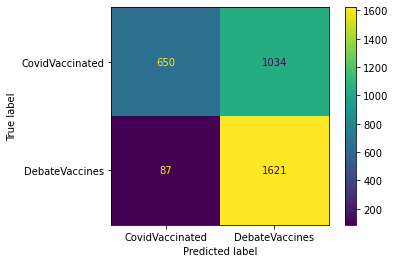

In [202]:
# Generated a ConfusionMatrixDisplay utilizing this DummyClassifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_dtc_gs, X_test, y_test);

In [203]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_dtc_gs_precision = precision_score(y_test, tfidf_dtc_gs_preds, pos_label='CovidVaccinated')
tfidf_dtc_gs_precision

0.8819538670284939

In [204]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_dtc_gs_recall = recall_score(y_test, tfidf_dtc_gs_preds, pos_label='CovidVaccinated')
tfidf_dtc_gs_recall

0.3859857482185273

In [205]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_dtc_gs_f1 = f1_score(y_test, tfidf_dtc_gs_preds, pos_label='CovidVaccinated')
tfidf_dtc_gs_f1

0.53696819496076

In [206]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_dtc_gs.best_params_

{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__min_samples_split': 2,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__tokenizer': None}

#### TfidfVectorizer + ExtraTreesClassifier

In [3]:
# Created a pipeline object with a TfidfVectorizer transformer and Extra Trees Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_etc_pipe = make_pipeline(TfidfVectorizer(), ExtraTreesClassifier())
tfidf_etc_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('extratreesclassifier', ExtraTreesClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'extratreesclassifier': ExtraTreesClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': Tr

In [210]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_etc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'extratreesclassifier__max_depth': [None, 5, 10, 15, 20],
    'extratreesclassifier__max_features': [None, 1_000, 2_000],
    'extratreesclassifier__min_samples_split': [None, 2, 5]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [211]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_etc_rs = RandomizedSearchCV(tfidf_etc_pipe, param_distributions=tfidf_etc_params, n_jobs=-1)

In [212]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_etc_rs.fit(X_train, y_train)
tfidf_etc_rs.score(X_train, y_train), tfidf_etc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.8262407862407862, 0.7216981132075472)

In [213]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_etc_rs.best_params_

{'tfidfvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__max_df': 0.8,
 'extratreesclassifier__min_samples_split': 2,
 'extratreesclassifier__max_features': None,
 'extratreesclassifier__max_depth': 20}

In [214]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_etc_new_params = {
    'tfidfvectorizer__max_df': [.8],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': [None],
    'tfidfvectorizer__tokenizer': [stemming_tokenizer],
    'extratreesclassifier__max_depth': [20],
    'extratreesclassifier__max_features': [None],
    'extratreesclassifier__min_samples_split': [2, 3, 4]
}

##### Hyperparameter Tuning using GridSearchCV

In [215]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_etc_gs = GridSearchCV(tfidf_etc_pipe, param_grid=tfidf_etc_new_params, n_jobs=-1)

In [216]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_etc_gs.fit(X_train, y_train)
tfidf_etc_gs.score(X_train, y_train), tfidf_etc_gs.score(X_test, y_test)

(0.8252579852579852, 0.7216981132075472)

In [217]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_etc_gs_preds".
tfidf_etc_gs_preds = tfidf_etc_gs.predict(X_test)

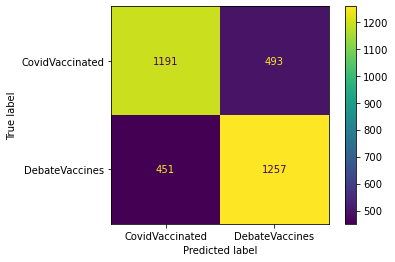

In [218]:
# Generated a ConfusionMatrixDisplay utilizing this Extra Trees Classifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_etc_gs, X_test, y_test);

In [219]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_etc_gs_precision = precision_score(y_test, tfidf_etc_gs_preds, pos_label='CovidVaccinated')
tfidf_etc_gs_precision

0.7253349573690622

In [220]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_etc_gs_recall = recall_score(y_test, tfidf_etc_gs_preds, pos_label='CovidVaccinated')
tfidf_etc_gs_recall

0.7072446555819477

In [221]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_etc_gs_f1 = f1_score(y_test, tfidf_etc_gs_preds, pos_label='CovidVaccinated')
tfidf_etc_gs_f1

0.7161755862898376

In [222]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_etc_gs.best_params_

{'extratreesclassifier__max_depth': 20,
 'extratreesclassifier__max_features': None,
 'extratreesclassifier__min_samples_split': 4,
 'tfidfvectorizer__max_df': 0.8,
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>}

#### TfidfVectorizer + RandomForestClassifier

In [227]:
# Created a pipeline object with a TfidfVectorizer transformer and Random Forest Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_rfc_pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
tfidf_rfc_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'randomforestclassifier': RandomForestClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_

In [228]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_rfc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__max_features': [None, 1_000, 2_000],
    'randomforestclassifier__min_samples_split': [None, 2, 5]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [229]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_rfc_rs = RandomizedSearchCV(tfidf_rfc_pipe, param_distributions=tfidf_rfc_params, n_jobs=-1)

In [230]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_rfc_rs.fit(X_train, y_train)
tfidf_rfc_rs.score(X_train, y_train), tfidf_rfc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.6712530712530712, 0.6674528301886793)

In [231]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_rfc_rs.best_params_

{'tfidfvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>,
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__max_df': 0.9,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__max_depth': 15}

In [232]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_rfc_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.1], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__tokenizer': [stemming_tokenizer],
    'randomforestclassifier__max_depth': [15],
    'randomforestclassifier__max_features': [None],
    'randomforestclassifier__min_samples_split': [2, 3, 4]
}

##### Hyperparameter Tuning using GridSearchCV

In [233]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_rfc_gs = GridSearchCV(tfidf_rfc_pipe, param_grid=tfidf_rfc_new_params, n_jobs=-1)

In [234]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_rfc_gs.fit(X_train, y_train)
tfidf_rfc_gs.score(X_train, y_train), tfidf_rfc_gs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(0.6712530712530712, 0.6665683962264151)

In [235]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_rfc_gs_preds".
tfidf_rfc_gs_preds = tfidf_rfc_gs.predict(X_test)

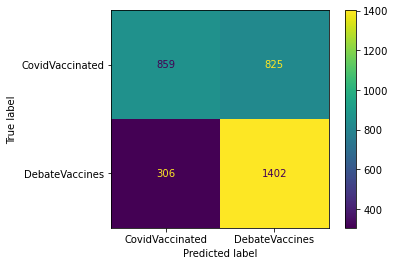

In [236]:
# Generated a ConfusionMatrixDisplay utilizing this Random Forest Classifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_rfc_gs, X_test, y_test);

In [237]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_rfc_gs_precision = precision_score(y_test, tfidf_rfc_gs_preds, pos_label='CovidVaccinated')
tfidf_rfc_gs_precision

0.7373390557939914

In [238]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_rfc_gs_recall = recall_score(y_test, tfidf_rfc_gs_preds, pos_label='CovidVaccinated')
tfidf_rfc_gs_recall

0.5100950118764845

In [239]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_rfc_gs_f1 = f1_score(y_test, tfidf_rfc_gs_preds, pos_label='CovidVaccinated')
tfidf_rfc_gs_f1

0.603018603018603

In [240]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_rfc_gs.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': None,
 'randomforestclassifier__min_samples_split': 4,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__min_df': 0.1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english',
 'tfidfvectorizer__tokenizer': <function __main__.stemming_tokenizer(doc)>}

#### TfidfVectorizer + GradientBoostingClassifier

In [241]:
# Created a pipeline object with a TfidfVectorizer transformer and Gradient Boosting Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
tfidf_gbc_pipe = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())
tfidf_gbc_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('gradientboostingclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'gradientboostingclassifier': GradientBoostingClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidf

In [242]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
tfidf_gbc_params = {
    'tfidfvectorizer__max_df': [.9, .8],
    'tfidfvectorizer__min_df': [.1, .2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'gradientboostingclassifier__max_depth': [None, 5, 10, 15, 20],
    'gradientboostingclassifier__max_features': [None, 1_000, 2_000],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [100, 150, 200]
}

##### Hyperparameter Tuning using RandomizedSearchCV

In [243]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
tfidf_gbc_rs = RandomizedSearchCV(tfidf_gbc_pipe, param_distributions=tfidf_gbc_params, n_jobs=-1)

In [244]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_gbc_rs.fit(X_train, y_train)
tfidf_gbc_rs.score(X_train, y_train), tfidf_gbc_rs.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'w

(0.658083538083538, 0.6202830188679245)

In [245]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
tfidf_gbc_rs.best_params_

{'tfidfvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__min_df': 0.2,
 'tfidfvectorizer__max_df': 0.9,
 'gradientboostingclassifier__n_estimators': 100,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__max_depth': None}

In [246]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
tfidf_gbc_new_params = {
    'tfidfvectorizer__max_df': [.9],
    'tfidfvectorizer__min_df': [.2], 
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__stop_words': [None],
    'tfidfvectorizer__tokenizer': [lemma_tokenizer],
    'gradientboostingclassifier__max_depth': [None],
    'gradientboostingclassifier__max_features': [None],
    'gradientboostingclassifier__min_samples_split': [2],
    'gradientboostingclassifier__n_estimators': [100]
}

##### Hyperparameter Tuning using GridSearchCV

In [247]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
tfidf_gbc_gs = GridSearchCV(tfidf_gbc_pipe, param_grid=tfidf_gbc_new_params, n_jobs=-1)

In [248]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
tfidf_gbc_gs.fit(X_train, y_train)
tfidf_gbc_gs.score(X_train, y_train), tfidf_gbc_gs.score(X_test, y_test)

(0.658083538083538, 0.6202830188679245)

In [249]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "tfidf_gbc_gs_preds".
tfidf_gbc_gs_preds = tfidf_gbc_gs.predict(X_test)

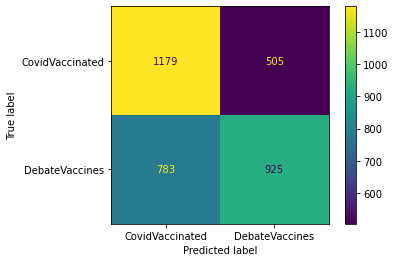

In [250]:
# Generated a ConfusionMatrixDisplay utilizing this Gradient Boosting Classifier estimator.
ConfusionMatrixDisplay.from_estimator(tfidf_gbc_gs, X_test, y_test);

In [251]:
# Calcualted the precision score after setting 'CovidVaccinated' as the positive label.
tfidf_gbc_gs_precision = precision_score(y_test, tfidf_gbc_gs_preds, pos_label='CovidVaccinated')
tfidf_gbc_gs_precision

0.6009174311926605

In [252]:
# Calcualted the recall score after setting 'CovidVaccinated' as the positive label.
tfidf_gbc_gs_recall = recall_score(y_test, tfidf_gbc_gs_preds, pos_label='CovidVaccinated')
tfidf_gbc_gs_recall

0.7001187648456056

In [253]:
# Calcualted the f1 score after setting 'CovidVaccinated' as the positive label.
tfidf_gbc_gs_f1 = f1_score(y_test, tfidf_gbc_gs_preds, pos_label='CovidVaccinated')
tfidf_gbc_gs_f1

0.6467361492046078

In [254]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
tfidf_gbc_gs.best_params_

{'gradientboostingclassifier__max_depth': None,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__n_estimators': 100,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__min_df': 0.2,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__tokenizer': <function __main__.lemma_tokenizer(doc)>}

## **Evaluation of Best Model: CV + MNB**

In [42]:
# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

In [43]:
new_defs= {
    'CovidVaccinated': 1, 
    'DebateVaccines' : 0   
}

In [44]:
y_test_encoded = y_test.map(new_defs)
y_test_encoded

9706     0
9505     0
3900     1
12562    0
11107    0
        ..
8416     0
11464    0
3110     1
1852     1
3067     1
Name: subreddit, Length: 3392, dtype: int64

In [45]:
incorrect_classifications = pd.DataFrame(X_test)[y_test != cvec_mnb_gs_preds]
incorrect_classifications

,title
3900,Vaccine and working out
1771,That’s how you know it’s working though.
2376,Pfizer phase 3 trial: numbers of occured cancer in vaccinated and placebo?
11827,"Diarrhea, gas, bloating, burping, belching, abdominal pain, digestion, and/or other gut and gastrointestinal issues after receiving a covid vaccine."
7376,"I know some vaccinated people who got covid twice, but no reinfections in my unvaccinated friends. how about you(r friends)?"
...,...
6739,side effects from moderna vs pfizer boosters?
1304,Were you ever vaccinated?
1686,Will you be vaccinating your children under 10 years old?
11464,"Serious: if I were to get a COVID vaccine, which one should I get?"


In [46]:
correct_classifications = pd.DataFrame(X_test)[y_test == cvec_mnb_gs_preds]
correct_classifications

,title
9706,Clinical Trial Issues #pfizergate
9505,Britain: Vaccinated people under 60 are twice as likely to die as unvaccinated people.
12562,An autistic child can achieve more than a dead one.
11107,ITS NOT ABOUT YOUR HEALTH
3495,"28M got Booster 6 hours ago, so far Booster is just like my 2nd shot"
...,...
53,Could I extend my EU Vaccination Certificate with a booster shot in the US?
12661,To all of you who don’t believe in vaccines
8416,Over a Thousand Scientific Study’s To Prove That The Covid 19 Vaccines Are Dangerous And All Those Pushing This Agenda Are Committing The Indictable Crime Of Gross Misconduct In Public Office
1852,6 months late but got my second Pfizer dose today
